At the request of the referee, how does our estimate of $M_{90, disk}$ compare with Pipe3D's stellar mass estimate?

In [16]:
from astropy.table import Table
import astropy.constants as const

import numpy as np

import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')
from dark_matter_mass_v1 import rot_fit_BB

import matplotlib.pyplot as plt
%matplotlib notebook

# Data

In [2]:
data_filename = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_v6.txt'

data = Table.read(data_filename, format='ascii.commented_header')

In [6]:
P3D_filename = '/Users/kellydouglass/Documents/Research/data/SDSS/dr15/manga/spectro/pipe3d/v2_4_3/2.4.3/manga.Pipe3D-v2_4_3.fits'

P3D = Table.read(P3D_filename, format='fits')

P3D[:10]

mangaid,objra,objdec,redshift,re_arc,pa,ellip,dl,re_kpc,log_mass,e_log_mass,log_sfr_ha,e_log_sfr_ha,log_sfr_ssp,e_log_sfr_ssp,log_mass_gas,e_log_mass_gas,age_lw_re_fit,e_age_lw_re_fit,alpha_age_lw_re_fit,e_alpha_age_lw_re_fit,age_mw_re_fit,e_age_mw_re_fit,alpha_age_mw_re_fit,e_alpha_age_mw_re_fit,zh_lw_re_fit,e_zh_lw_re_fit,alpha_zh_lw_re_fit,e_alpha_zh_lw_re_fit,zh_mw_re_fit,e_zh_mw_re_fit,alpha_zh_mw_re_fit,e_alpha_zh_mw_re_fit,av_ssp_re,e_av_ssp_re,av_gas_re,e_av_gas_re,oh_re_fit_o3n2,e_oh_re_fit_o3n2,alpha_oh_re_fit_o3n2,e_alpha_oh_re_fit_o3n2,oh_re_fit_n2,e_oh_re_fit_n2,alpha_oh_re_fit_n2,e_alpha_oh_re_fit_n2,oh_re_fit_ons,e_oh_re_fit_ons,alpha_oh_re_fit_ons,e_alpha_oh_re_fit_ons,oh_re_fit_pyqz,e_oh_re_fit_pyqz,alpha_oh_re_fit_pyqz,e_alpha_oh_re_fit_pyqz,oh_re_fit_t2,e_oh_re_fit_t2,alpha_oh_re_fit_t2,e_alpha_oh_re_fit_t2,oh_re_fit_m08,e_oh_re_fit_m08,alpha_oh_re_fit_m08,e_alpha_oh_re_fit_m08,oh_re_fit_t04,e_oh_re_fit_t04,alpha_oh_re_fit_t04,e_alpha_oh_re_fit_t04,no_re_fit_epm09,e_no_re_fit_epm09,alpha_no_re_fit_epm09,e_alpha_no_re_fit_epm09,no_re_fit_n2s2,e_no_re_fit_n2s2,alpha_no_re_fit_n2s2,e_alpha_no_re_fit_n2s2,log_nii_ha_cen,e_log_nii_ha_cen,log_oiii_hb_cen,e_log_oiii_hb_cen,log_sii_ha_cen,e_log_sii_ha_cen,log_oii_hb_cen,e_log_oii_hb_cen,ew_ha_cen,e_ew_ha_cen,ion_class_cen,sigma_cen,e_sigma_cen,sigma_cen_ha,e_sigma_cen_ha,vel_sigma_re,e_vel_sigma_re,lambda_re,e_lambda_re,plateifu,plate,ifudsgn
,degree,degree,,arcsec,degrees,,,kpc,log(msun),log(msun),log(msun/yr),log(msun/yr),log(msun/yr),log(msun/yr),log(msun),log(msun),log(yr),log(yr),,,log(yr),log(yr),,,log(yr),log(yr),,,log(yr),log(yr),,,mag,mag,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,km / s,km / s,km / s,km / s,,,,,,,
bytes128,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes128,int32,int32
manga-10001-12701,133.3711,57.598427,0.039515216,5.16633,158.2584,0.9089005,169.82077,3.9365368,9.993362,0.09378911,-0.11360164,0.06162829,0.321006,0.0030126863,9.30276,0.23200081,8.627869,0.030078521,-0.04584963,0.03300304,9.638159,0.07926918,0.040035605,0.08697648,-0.22109625,0.015437972,-0.11681557,0.016939,-0.34850442,0.036842354,-0.23933342,0.040424522,0.44457963,0.05640487,0.67660224,0.06749492,8.389801,0.009199213,-0.015966777,0.0077317283,8.388852,0.0055929385,-0.040406123,0.0047007366,8.38345,0.024292018,-0.17692971,0.020416886,8.79137,0.009953575,-0.13061059,0.008365752,8.707489,0.009148997,-0.04548534,0.0076895226,8.505277,0.0133201275,-0.023119316,0.011195262,8.709762,0.017676404,-0.044656843,0.014856613,-0.94510114,0.01739015,-0.13413328,0.014616024,-1.2244614,0.019293755,-0.19656102,0.01621596,-0.5920273,0.024525521,-0.06546027,0.027029455,-0.37301385,0.016863849,0.4405697,0.018996716,-22.32854,1.9747354,-10.0,69.21875,8.31978,10.500083,7.8046036,0.5406162,0.26550058,0.59190524,0.581378,10001-12701,10001,12701
manga-10001-12702,133.68567,57.48025,0.041055806,7.01311,102.3759,0.80141026,178.72545,5.606923,10.108313,0.10324214,-0.6064556,0.06187228,0.1583787,0.0016176149,9.071214,1.183896,9.034336,0.032536954,-0.25130534,0.035700507,9.87485,0.040210534,0.05099766,0.044120185,-0.25836778,0.038935095,-0.027706148,0.042720735,-0.31041998,0.074788965,0.10411369,0.082060665,0.45788527,0.032583896,0.4127637,0.21548133,8.434221,0.013942637,-0.12731175,0.011718467,8.380596,0.022753915,-0

## Join the two tables together

In [9]:
data['P3D_logMstar'] = np.nan

for i in range(len(data)):
    
    gal_name = 'manga-' + str(data['MaNGA_plate'][i]) + '-' + str(data['MaNGA_IFU'][i])
    
    i_P3D = np.argwhere(P3D['mangaid'] == gal_name)
    
    if len(i_P3D) > 0:
        data['P3D_logMstar'][i] = P3D['log_mass'][i_P3D[0]]

## Select galaxies with good fits

### Calculate $V_{90}$

In [17]:
################################################################################
# Convert r from arcsec to kpc
#-------------------------------------------------------------------------------
H0 = 100

dist_to_galaxy_Mpc = (const.c.to('km/s')*data['NSA_redshift']/H0).value
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

data['R90_kpc'] = dist_to_galaxy_kpc*np.tan(data['NSA_elpetro_th90']*(1./60)*(1./60)*(np.pi/180))
#-------------------------------------------------------------------------------

data['V90_kms'] = rot_fit_BB(data['R90_kpc'], 
                             [data['Vmax_map'], 
                              data['Rturn_map'], 
                              data['alpha_map']])

/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


### Calculate the mass ratio

In [18]:
data['M90_Mdisk_ratio'] = 10**(data['M90_map'] - data['M90_disk_map'])

### Apply cuts to data

In [19]:
bad_boolean = np.logical_or.reduce([np.isnan(data['M90_map']), 
                                    np.isnan(data['M90_disk_map']), 
                                    data['alpha_map'] > 99, 
                                    data['ba_map'] > 0.998, 
                                    data['V90_kms']/data['Vmax_map'] < 0.9, 
                                    (data['Tidal'] & (data['DL_merge'] > 0.97)), 
                                    data['map_frac_unmasked'] < 0.05, 
                                    (data['map_frac_unmasked'] > 0.13) & (data['DRP_map_smoothness'] > 1.96), 
                                    (data['map_frac_unmasked'] > 0.07) & (data['DRP_map_smoothness'] > 2.9), 
                                    (data['map_frac_unmasked'] > -0.0638*data['DRP_map_smoothness'] + 0.255) & (data['DRP_map_smoothness'] > 1.96), 
                                    data['M90_Mdisk_ratio'] > 1050])

good_galaxies = data[~bad_boolean]

# Compare $M_{90,disk}$ and $M_{*,Pipe3D}$

<IPython.core.display.Javascript object>


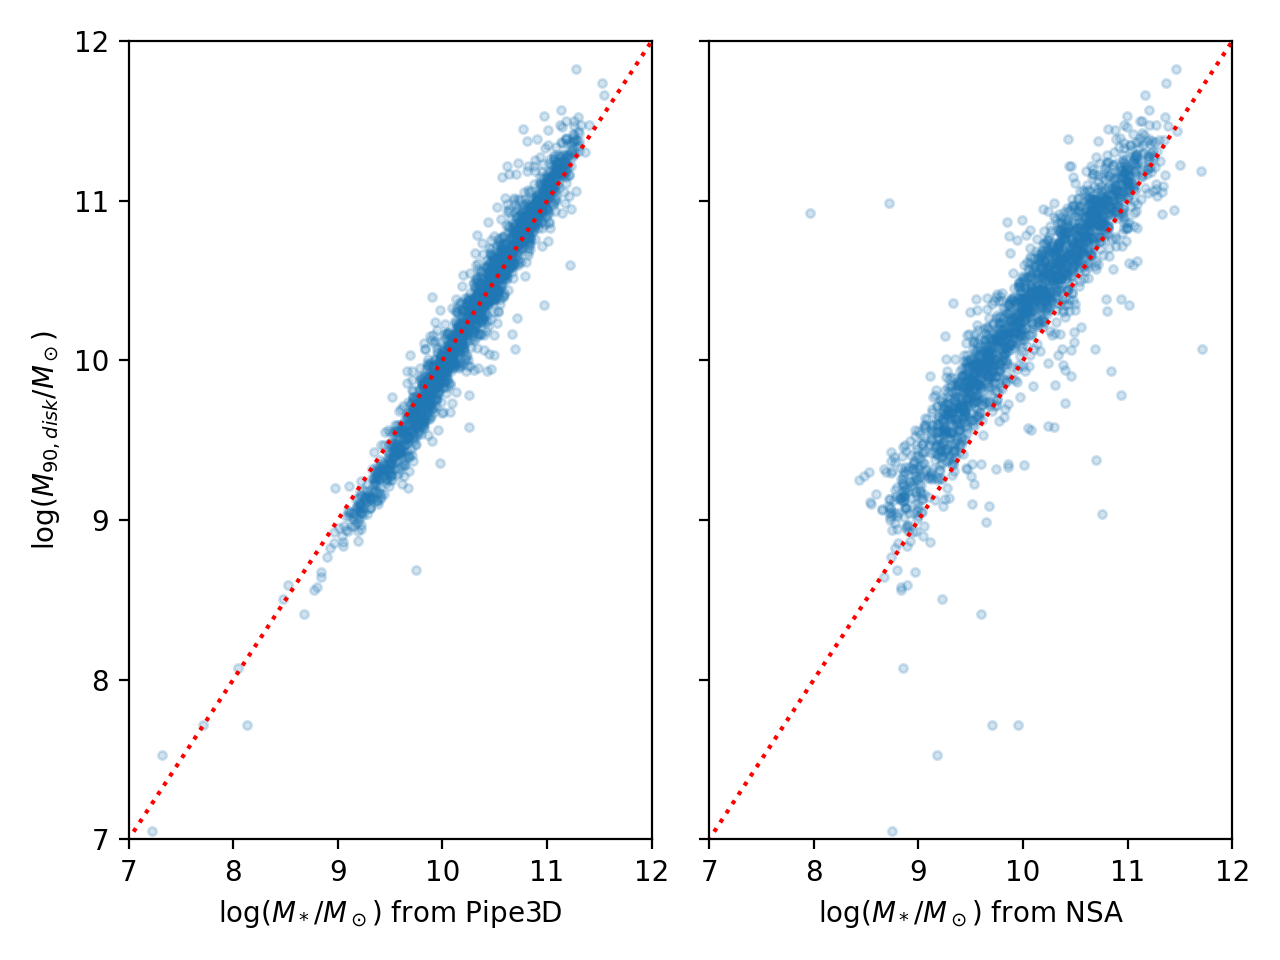

In [28]:
fig, ax = plt.subplots(1, 2, tight_layout=True, sharey=True)


################################################################################
# Pipe3D
#-------------------------------------------------------------------------------
ax[0].plot(good_galaxies['P3D_logMstar'], good_galaxies['M90_disk_map'], '.', 
           alpha=0.2)

ax[0].plot([5,12], [5,12], 'r:')

ax[0].set_ylim(7, 12)
ax[0].set_xlim(7, 12)

ax[0].set_ylabel('log($M_{90, disk}/M_\odot$)')
ax[0].set_xlabel('log($M_*/M_\odot$) from Pipe3D')
################################################################################


################################################################################
# NSA
#-------------------------------------------------------------------------------
ax[1].plot(np.log10(good_galaxies['NSA_Mstar']), good_galaxies['M90_disk_map'], 
           '.', alpha=0.2)

ax[1].plot([5,12], [5,12], 'r:')

ax[1].set_xlim(7, 12)

ax[1].set_xlabel('log($M_*/M_\odot$) from NSA');
################################################################################